We use the crystal module to define the crystal structure, and the vacancy jump network; the OnsagerCalc module provides the VacancyMediated calculator.

In [1]:
import numpy as np
from onsager import OnsagerCalc
from onsager import crystal
import matplotlib.pyplot as plt
%matplotlib inline

We use the FCC classmethod to create a FCC crystal; alternatively, we could pass the lattice and basis.

In [2]:
Nifcc = crystal.Crystal.FCC(3.43, 'Ni')

In [3]:
print(Nifcc)

#Lattice:
  a1 = [ 0.     1.715  1.715]
  a2 = [ 1.715  0.     1.715]
  a3 = [ 1.715  1.715  0.   ]
#Basis:
  (Ni) 0.0 = [ 0.  0.  0.]


The sitelist is the list of Wyckoff positions; the jumpnetwork defines the vacancy jumps on the FCC lattice. The structure of the jumpnetwork is a list of lists: grouped by symmetry unique jumps, then all of the jumps in that set. Each jump is a tuple of initial to final indices in the crystal, and the dx vector (in Cartesian coordinates).

In [4]:
sitelist = Nifcc.sitelist(Nifcc.chemindex('Ni'))
vacancyjumps = Nifcc.jumpnetwork(Nifcc.chemindex('Ni'), 0.75*3.43)

In [5]:
len(vacancyjumps)

1

In [6]:
for (i,j), dx in vacancyjumps[0]:
    print(i, '->', j, dx)

0 -> 0 [ 1.715 -1.715  0.   ]
0 -> 0 [-1.715  1.715 -0.   ]
0 -> 0 [ 0.     1.715  1.715]
0 -> 0 [-0.    -1.715 -1.715]
0 -> 0 [-1.715  0.    -1.715]
0 -> 0 [ 1.715 -0.     1.715]
0 -> 0 [-1.715  0.     1.715]
0 -> 0 [ 1.715 -0.    -1.715]
0 -> 0 [ 1.715  1.715  0.   ]
0 -> 0 [-1.715 -1.715 -0.   ]
0 -> 0 [ 0.     1.715 -1.715]
0 -> 0 [-0.    -1.715  1.715]


This constructs the VacancyMediated calculator. It takes a while to construct, as there's a lot behind the scenes. This includes constructing the stars that define the thermodynamic shells, the kinetic shells (thermo + 1), the vector stars, and creates the Green function calculator. However, once constructed, the $L_{ij}$ calculation is quite fast.

In [7]:
Nidiffuser = OnsagerCalc.VacancyMediated(Nifcc, Nifcc.chemindex('Ni'), sitelist, 
                                         vacancyjumps, 2)

The interactlist are symmetry-unique solute-vacancy configurations. For $N_\text{thermo}=2$, there are 4 stars: $\frac{a}2\langle110\rangle$, $a\langle100\rangle$, $\frac{a}2\langle112\rangle$, and $a\langle200\rangle$. For Si in Ni, the first three have non-zero interaction energies, while the fourth is zero. The states, as written, are the solute (basis index + lattice position) : vacancy (basis index + lattice position), and $dx$ is the (Cartesian) vector separating them.

In [8]:
for state in Nidiffuser.interactlist():
    print(state)

0.[0,0,0]:0.[-1,1,0] (dx=[1.715,-1.715,0.0])
0.[0,0,0]:0.[-1,1,1] (dx=[3.43,0.0,0.0])
0.[0,0,0]:0.[-2,1,0] (dx=[1.715,-3.43,-1.715])
0.[0,0,0]:0.[-2,2,0] (dx=[3.43,-3.43,0.0])


The fastest way to construct all of the transition states is to specify the vacancy jumps, then the solute-vacancy interactions, and impose LIMB (linear interpolation of migration barrier) approximation. It's mostly accurate, and so we just correct the few cases where it fails. *Remember*: we specify transition state energies and prefactors, and so we have to remember the solute-vacancy binding energies are included in the transition states.

In [9]:
nu0 = 4.8e3  # 10^12 Hz, 10^-20 m^2
dE0 = 1.074  # activation barrier eV
NiSidef = {'preV': np.array([1.]), 'eneV': np.array([0.]),
           'preS': np.array([1.]), 'eneS': np.array([0.]),
           'preT0': np.array([nu0]), 'eneT0': np.array([dE0])}
NiSidef['preSV'] = np.array([1., 1., 1., 1.])
NiSidef['eneSV'] = np.array([-0.100, 0.011, 0.045, 0.0])  # solute-vacancy interaction

In [10]:
NiSidef.update(Nidiffuser.makeLIMBpreene(**NiSidef))  # implement LIMB

In [11]:
for k,v in zip(NiSidef.keys(), NiSidef.values()):
    print(k, v)

eneV [ 0.]
preSV [ 1.  1.  1.  1.]
preV [ 1.]
eneT1 [ 1.024   0.974   1.0465  1.0295  1.0795  1.102   1.0965  1.119   1.0965
  1.0965  1.0965  1.074   1.074   1.074 ]
preT2 [ 4800.]
eneT2 [ 0.974]
eneS [ 0.]
preS [ 1.]
preT0 [ 4800.]
eneT0 [ 1.074]
preT1 [ 4800.  4800.  4800.  4800.  4800.  4800.  4800.  4800.  4800.  4800.
  4800.  4800.  4800.  4800.]
eneSV [-0.1    0.011  0.045  0.   ]


We first change the $\omega^{(2)}$ jump barrier; then we set all of the prefactors to the higher value. Finally, we'll identify the $\omega^{(1)}$ jump that involves the vacancy next to the solute.

In [12]:
NiSidef['eneT2'][0] = 0.891 + NiSidef['eneSV'][0]  # fix omega2
NiSidef['preT1'] = 5.15e3 * np.ones_like(NiSidef['preT1'])  # fix omega1 prefactors
NiSidef['preT2'][0] = 5.15e3

In [13]:
for S1, S2 in Nidiffuser.omegalist(1)[0]:
    print(S1, '->', S2)

0.[0,0,0]:0.[-1,1,0] (dx=[1.715,-1.715,0.0]) -> 0.[0,0,0]:0.[-2,2,0] (dx=[3.43,-3.43,0.0])
0.[0,0,0]:0.[1,0,0] (dx=[0.0,1.715,1.715]) -> 0.[0,0,0]:0.[0,1,0] (dx=[1.715,-0.0,1.715])
0.[0,0,0]:0.[-1,0,0] (dx=[-0.0,-1.715,-1.715]) -> 0.[0,0,0]:0.[-2,1,0] (dx=[1.715,-3.43,-1.715])
0.[0,0,0]:0.[0,0,1] (dx=[1.715,1.715,0.0]) -> 0.[0,0,0]:0.[-1,1,1] (dx=[3.43,0.0,0.0])
0.[0,0,0]:0.[-1,1,1] (dx=[3.43,0.0,0.0]) -> 0.[0,0,0]:0.[-2,2,1] (dx=[5.1450000000000005,-1.715,0.0])
0.[0,0,0]:0.[1,1,-1] (dx=[0.0,0.0,3.43]) -> 0.[0,0,0]:0.[0,2,-1] (dx=[1.715,-1.715,3.43])
0.[0,0,0]:0.[-2,1,0] (dx=[1.715,-3.43,-1.715]) -> 0.[0,0,0]:0.[-3,2,0] (dx=[3.43,-5.1450000000000005,-1.715])
0.[0,0,0]:0.[1,0,1] (dx=[1.715,3.43,1.715]) -> 0.[0,0,0]:0.[0,1,1] (dx=[3.43,1.715,1.715])
0.[0,0,0]:0.[-1,0,-1] (dx=[-1.715,-3.43,-1.715]) -> 0.[0,0,0]:0.[-2,1,-1] (dx=[0.0,-5.1450000000000005,-1.715])
0.[0,0,0]:0.[1,1,0] (dx=[1.715,1.715,3.43]) -> 0.[0,0,0]:0.[0,2,0] (dx=[3.43,-0.0,3.43])
0.[0,0,0]:0.[-2,0,1] (dx=[1.715,-1.715,-3

Specifically look for the case where the initial and final states are at first neighbor:

In [14]:
for j, (S1,S2) in enumerate(Nidiffuser.omegalist(1)[0]):
    if np.isclose(np.dot(S1.dx, S1.dx), 0.5*3.43**2) and \
        np.isclose(np.dot(S2.dx,S2.dx), 0.5*3.43**2):
            NiSidef['eneT1'][j] = 1.003 + NiSidef['eneSV'][0]  # fix omega1 near solute

This is a little bit of python to "hide" the conversion of T into energy, and use the dictionary we built to construct the inputs to the $L_{ij}$ calculator.

In [15]:
def NiSiLij(T):
    return Nidiffuser.Lij(*Nidiffuser.preene2betafree(T*0.026/300, **NiSidef))

Our prefactor will make the units $(\text{eV A ns})^{-1}$.

In [16]:
for T in range(500, 1501, 50):
    pre = 300/(0.026*T*Nifcc.volume)
    Lvv, Lss, Lsv, L1vv = NiSiLij(T)
    print(T, Lsv[0,0]/Lss[0,0], pre*Lvv[0,0], pre*Lsv[0,0], pre*Lss[0,0])

500 0.784406826564 2.22517060121e-06 9.73358983796e-05 0.000124088540644
550 0.708551697488 1.92530648438e-05 0.000534518072421 0.000754381189568
600 0.628310650181 0.000115385795975 0.002119825703 0.00337384970697
650 0.546476785379 0.000521649522805 0.00651274224496 0.0119176924239
700 0.465192381867 0.00189065769081 0.0162711542892 0.0349772587072
750 0.385981174853 0.00574397604805 0.0341653764172 0.0885156547602
800 0.309847957366 0.0151243412369 0.06153569641 0.198599651691
850 0.237394358247 0.0354059512916 0.0958024040707 0.403558049054
900 0.168925485085 0.0751642905812 0.127554387385 0.755092621581
950 0.104537885462 0.146981303834 0.137791953457 1.31810542033
1000 0.0441875145103 0.268067501522 0.0958544183704 2.16926476704
1050 -0.0122599963097 0.460613154326 -0.0416169990797 3.39453602011
1100 -0.064993353166 0.751823859343 -0.33055741173 5.08601873311
1150 -0.114230529424 1.17363944631 -0.838276323621 7.33846133647
1200 -0.160201745644 1.76217104959 -1.6413934163 10.24578

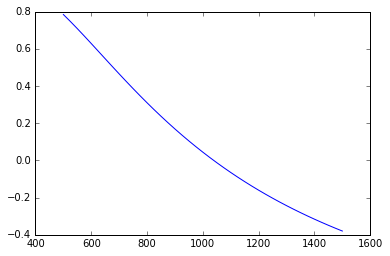

In [17]:
Temp = np.arange(500., 1501., 25.)
dragratio = Temp.copy()
for i, T in enumerate(Temp):
    Lvv, Lss, Lsv, L1vv = NiSiLij(T)
    dragratio[i] = Lsv[0,0]/Lss[0,0]
DragPlot = plt.plot(Temp, dragratio)
plt.show()

In [18]:
dragratio

array([ 0.78440683,  0.74722572,  0.7085517 ,  0.66879   ,  0.62831065,
        0.58744355,  0.54647679,  0.50565717,  0.46519238,  0.42525403,
        0.38598117,  0.3474841 ,  0.30984796,  0.27313632,  0.23739436,
        0.2026518 ,  0.16892549,  0.13622165,  0.10453789,  0.07386481,
        0.04418751,  0.01548676, -0.01226   , -0.03907777, -0.06499335,
       -0.09003471, -0.11423053, -0.13760985, -0.16020175, -0.18203506,
       -0.20313824, -0.22353918, -0.24326511, -0.2623425 , -0.28079701,
       -0.29865345, -0.31593574, -0.33266692, -0.34886915, -0.36456369,
       -0.37977093])